In [ ]:
# Install dependencies if not already installed
!pip install scikit-learn yellowbrick

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import resample
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset (replace 'FILE_ID' with the actual file ID from Google Drive link)
file_id = 'Online Retail.xlsx'
file_path = f'/content/drive/MyDrive/{file_id}'
data = pd.read_excel(file_path, engine='openpyxl')

# Display the first few rows of the dataset to understand its structure
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Convert 'UnitPrice' and any other columns to numeric, handle missing values if needed
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')
data = data.dropna()  # Drop rows with missing values for simplicity

# Feature selection for clustering (for example: Quantity, UnitPrice)
X = data[['Quantity', 'UnitPrice']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Initialize clustering models
euclidean_kmeans = KMeans()  # Euclidean KMeans
hierarchical = AgglomerativeClustering(metric='euclidean', linkage='ward')  # Hierarchical Clustering
kmeans = KMeans()  # Standard KMeans Clustering

# Create a list of models for iteration
models = [('Euclidean KMeans', euclidean_kmeans),
          ('Hierarchical Clustering', hierarchical),
          ('KMeans Clustering', kmeans)]


Evaluating Euclidean KMeans Model:


/usr/local/lib/python3.10/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


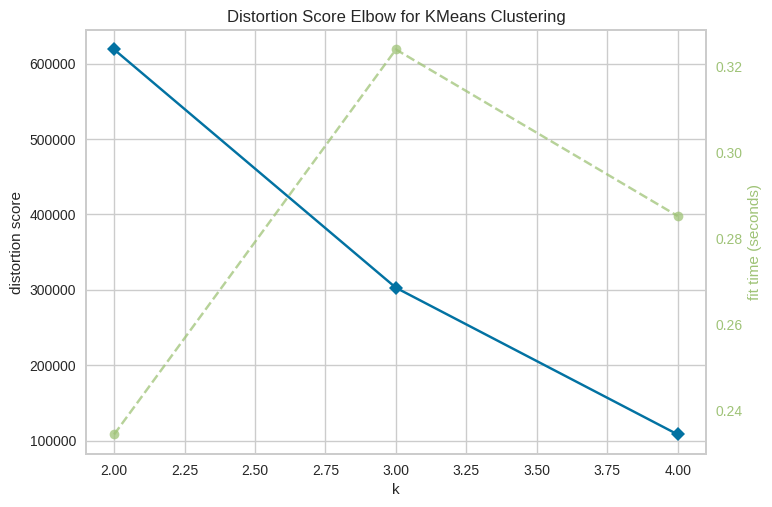

No optimal k found for Euclidean KMeans. Setting default k=3.
Calinski-Harabasz Score: 342937.6706452003
Davies-Bouldin Score: 0.03635305908250686


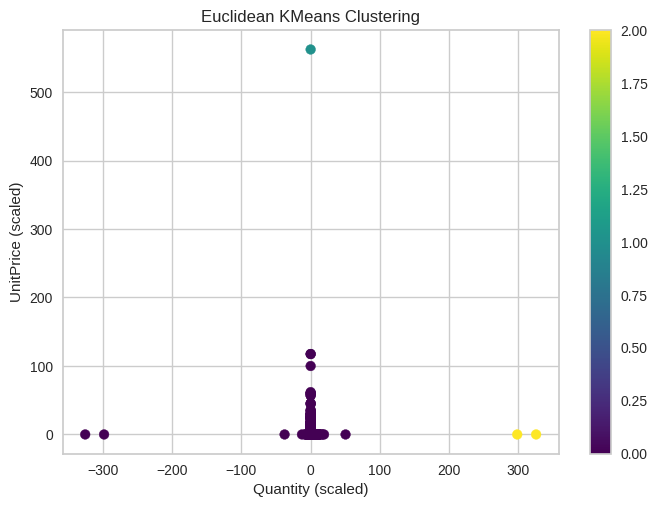


Evaluating Hierarchical Clustering Model:
Silhouette Score: 0.9475327359644048


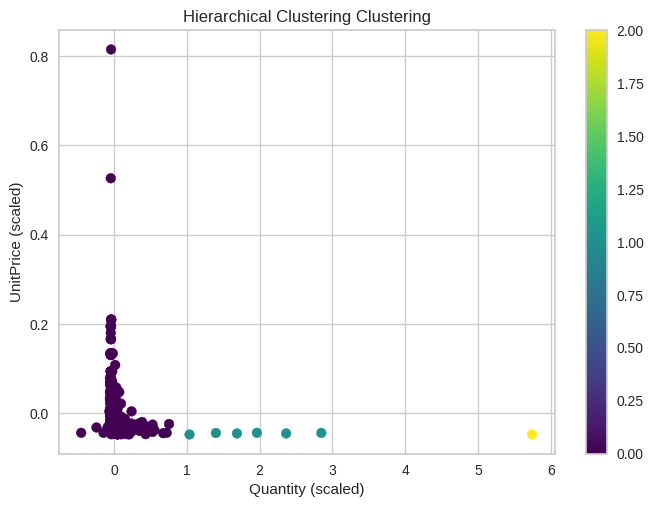


Evaluating KMeans Clustering Model:


/usr/local/lib/python3.10/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


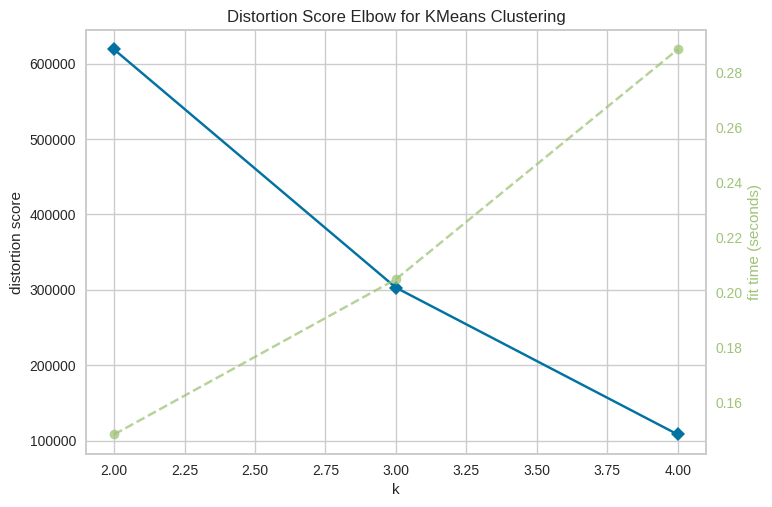

No optimal k found for KMeans Clustering. Setting default k=3.
Calinski-Harabasz Score: 343156.1175231203
Davies-Bouldin Score: 0.03634646013574331


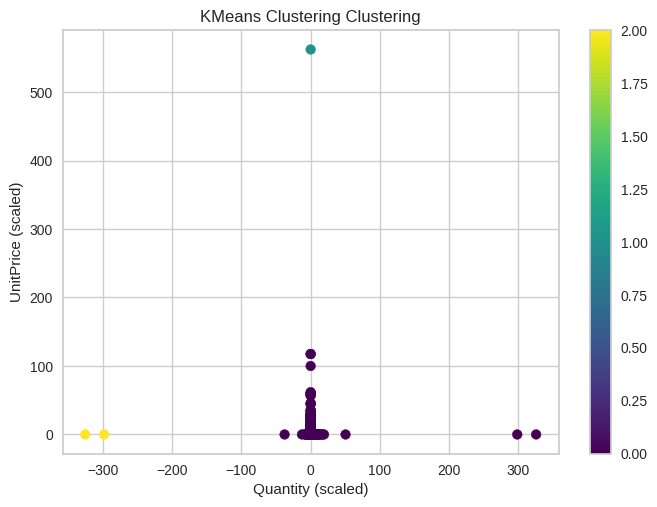

In [ ]:
# Pipeline evaluasi dan visualisasi dengan sampling untuk Hierarchical Clustering
for model_name, model in models:
    print(f"\nEvaluating {model_name} Model:")

    if model_name == 'Hierarchical Clustering':
        # Perform sampling for hierarchical clustering to limit memory usage
        if len(X_scaled) > hierarchical_sample_size:
            X_hierarchical = resample(X_scaled, n_samples=hierarchical_sample_size, random_state=42)
        else:
            X_hierarchical = X_scaled

        # Fit AgglomerativeClustering with limited data and clusters to reduce memory load
        hierarchical_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
        labels = hierarchical_model.fit_predict(X_hierarchical)

        # Calculate Silhouette Score only if more than one cluster is present
        unique_labels = set(labels)
        if len(unique_labels) > 1:
            silhouette_avg = silhouette_score(X_hierarchical, labels)
            print(f"Silhouette Score: {silhouette_avg}")
        else:
            print("Silhouette Score: Cannot be calculated with a single cluster")

        # Plot cluster assignments for Hierarchical clustering (use the sampled data)
        plt.figure()
        plt.scatter(X_hierarchical[:, 0], X_hierarchical[:, 1], c=labels, cmap='viridis')
        plt.title(f'{model_name} Clustering')
        plt.xlabel('Quantity (scaled)')
        plt.ylabel('UnitPrice (scaled)')
        plt.colorbar()
        plt.show()

    else:
        # Visualize the Knee/Elbow point for KMeans and Euclidean KMeans
        visualizer = KElbowVisualizer(model, k=(2,5))  # Limit k to a maximum of 5 for faster evaluation
        visualizer.fit(X_scaled)
        visualizer.show()

        # Check if an optimal k was found
        optimal_k = visualizer.elbow_value_
        if optimal_k is None:
            print(f"No optimal k found for {model_name}. Setting default k=3.")
            optimal_k = 3  # Set a default value if elbow point is not found

        # Apply model with the determined or default optimal_k
        model.set_params(n_clusters=optimal_k)
        model.fit(X_scaled)
        labels = model.labels_

        # Additional evaluation metrics (using full data for non-hierarchical models)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        print(f"Calinski-Harabasz Score: {ch_score}")
        print(f"Davies-Bouldin Score: {db_score}")

        # Plot cluster assignments for KMeans
        plt.figure()
        plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
        plt.title(f'{model_name} Clustering')
        plt.xlabel('Quantity (scaled)')
        plt.ylabel('UnitPrice (scaled)')
        plt.colorbar()
        plt.show()

In [ ]:
# Load the new dataset (clusteringweek06.csv)
file_path = '/content/drive/MyDrive/clusteringweek06.csv'
data = pd.read_csv(file_path)

data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [ ]:
# clustering
X = data[['x1', 'x2']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



Evaluating Euclidean KMeans Model:


/usr/local/lib/python3.10/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


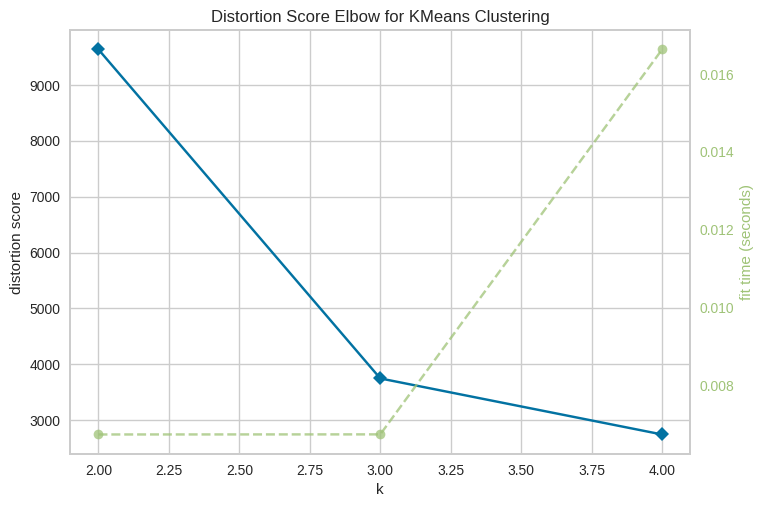

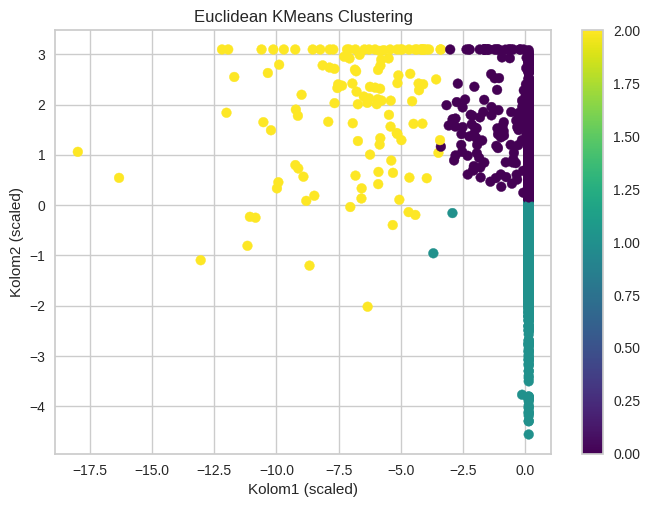


Evaluating Hierarchical Clustering Model:


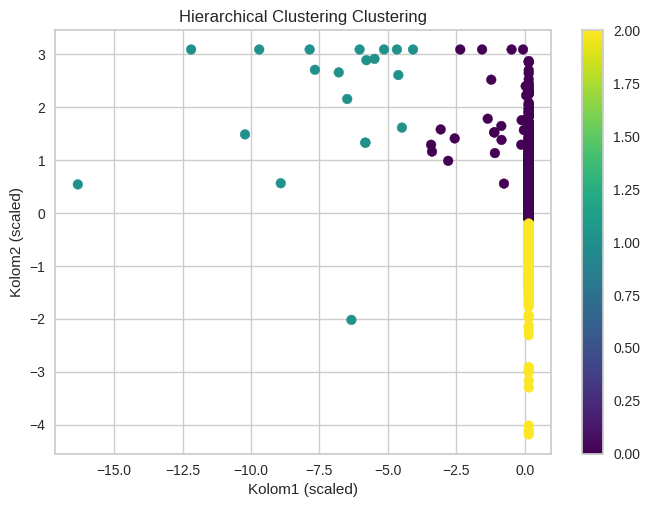


Evaluating KMeans Clustering Model:


/usr/local/lib/python3.10/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


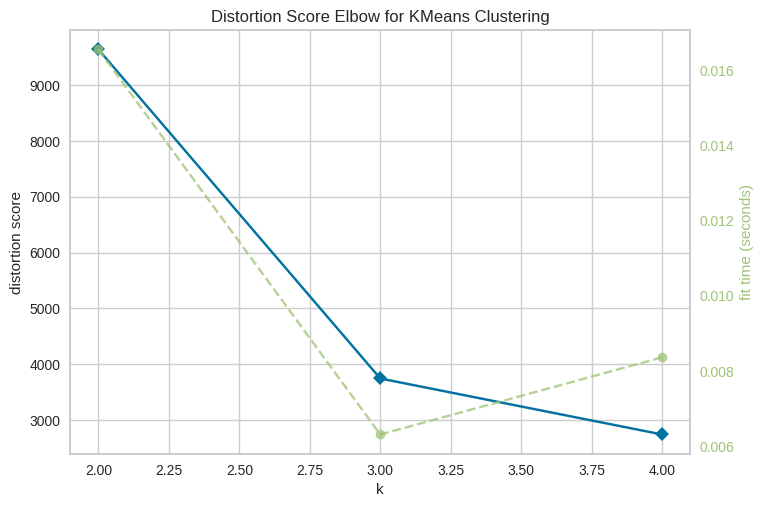

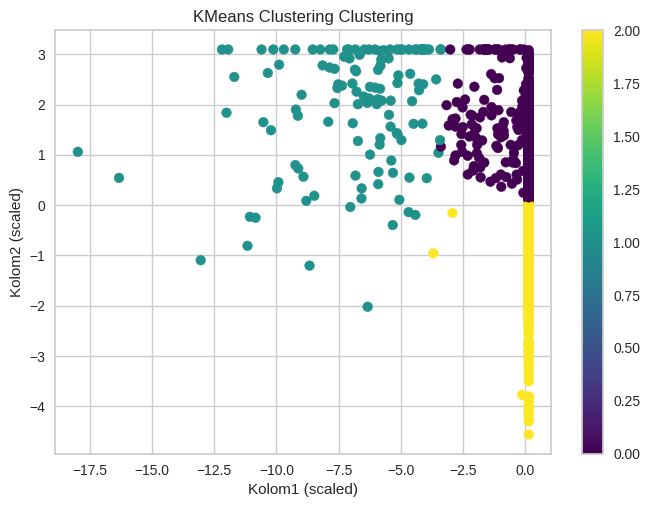

In [ ]:
# Inisialisasi model clustering
models = [
    ('Euclidean KMeans', KMeans()),
    ('Hierarchical Clustering', AgglomerativeClustering(metric='euclidean', linkage='ward')),
    ('KMeans Clustering', KMeans())
]

for model_name, model in models:
    print(f"\nEvaluating {model_name} Model:")

    if model_name == 'Hierarchical Clustering':
        if len(X_scaled) > hierarchical_sample_size:
            X_hierarchical = resample(X_scaled, n_samples=hierarchical_sample_size, random_state=42)
        else:
            X_hierarchical = X_scaled

        hierarchical_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
        labels = hierarchical_model.fit_predict(X_hierarchical)

        plt.figure()
        plt.scatter(X_hierarchical[:, 0], X_hierarchical[:, 1], c=labels, cmap='viridis')
        plt.title(f'{model_name} Clustering')
        plt.xlabel('Kolom1 (scaled)')
        plt.ylabel('Kolom2 (scaled)')
        plt.colorbar()
        plt.show()
    else:
        visualizer = KElbowVisualizer(model, k=(2,5))
        visualizer.fit(X_scaled)
        visualizer.show()

        optimal_k = visualizer.elbow_value_ if visualizer.elbow_value_ else 3
        model.set_params(n_clusters=optimal_k)
        model.fit(X_scaled)
        labels = model.labels_

        plt.figure()
        plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
        plt.title(f'{model_name} Clustering')
        plt.xlabel('Kolom1 (scaled)')
        plt.ylabel('Kolom2 (scaled)')
        plt.colorbar()
        plt.show()


In [39]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

evaluation_results = {}

for model_name, model in models:
    print(f"Evaluating {model_name}")

    if model_name == 'Hierarchical Clustering':
        labels = hierarchical_model.fit_predict(X_hierarchical)
        silhouette_avg = silhouette_score(X_hierarchical, labels)
        davies_bouldin = davies_bouldin_score(X_hierarchical, labels)
    else:
        model.fit(X_scaled)
        labels = model.labels_
        silhouette_avg = silhouette_score(X_scaled, labels)
        davies_bouldin = davies_bouldin_score(X_scaled, labels)

    evaluation_results[model_name] = {
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': davies_bouldin
    }

for model_name, metrics in evaluation_results.items():
    print(f"\nModel: {model_name}")
    print(f"Silhouette Score: {metrics['Silhouette Score']:.4f}")
    print(f"Davies-Bouldin Index: {metrics['Davies-Bouldin Index']:.4f}")


Evaluating Euclidean KMeans
Evaluating Hierarchical Clustering
Evaluating KMeans Clustering

Model: Euclidean KMeans
Silhouette Score: 0.5663
Davies-Bouldin Index: 0.5322

Model: Hierarchical Clustering
Silhouette Score: 0.5499
Davies-Bouldin Index: 0.5428

Model: KMeans Clustering
Silhouette Score: 0.5664
Davies-Bouldin Index: 0.5322
